In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader


coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [53]:
pdic = pd.read_csv('/media/ck/Elements/Africa/WestAfrica/NFLICS/tables/coresPower_MSG_-40_700km2_-50points_dominant_vcores_14-4W_15UTC.csv', na_values=[-999])
pdic = pd.DataFrame.from_dict(pdic)
tab = pdic
tab['time'] = tab['date']

In [54]:
tab

,id,date,lon,lat,hour,month,year,day,time
0,0,2004-03-31 15:00:00,-5.332872,11.390175,15,3,2004,31,2004-03-31 15:00:00
1,1,2004-03-31 15:00:00,-4.569304,11.611669,15,3,2004,31,2004-03-31 15:00:00
2,2,2004-04-12 15:00:00,-5.737114,10.680237,15,4,2004,12,2004-04-12 15:00:00
3,3,2004-04-12 15:00:00,-4.883715,12.230894,15,4,2004,12,2004-04-12 15:00:00
4,4,2004-04-16 15:00:00,-9.015965,10.546932,15,4,2004,16,2004-04-16 15:00:00
...,...,...,...,...,...,...,...,...,...
5831,5831,2018-08-29 15:00:00,-10.273607,15.999989,15,8,2018,29,2018-08-29 15:00:00
5832,5832,2018-08-30 15:00:00,-4.120147,14.210988,15,8,2018,30,2018-08-30 15:00:00
5833,5833,2018-08-31 15:00:00,-4.075231,14.210988,15,8,2018,31,2018-08-31 15:00:00
5834,5834,2018-08-31 15:00:00,-4.389641,14.998279,15,8,2018,31,2018-08-31 15:00:00


In [55]:
print(tab.lon.max(), tab.lon.min(), tab.lat.max(), tab.lat.min())

-4.030315322984835 -13.956699212505546 16.99664099988836 10.502484461110708


In [56]:
box = [-9,-7,10.5,11]
np.sum((tab.lon>box[0]) & (tab.lon<box[1]) & (tab.lat>box[2]) & (tab.lat<box[3]))

95

In [57]:
tab = tab.loc[(tab.lon>box[0]) & (tab.lon<box[1]) & (tab.lat>box[2]) & (tab.lat<box[3])]

In [58]:
len(np.unique(tab.time))

86

In [59]:
def cut_kernel(xpos, ypos, arr, date, lon, lat):

    #AMSRE 0.25 degrees ~ 27.5 km
    dist = 10

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)


    # if (np.sum(np.isfinite(kernel)) < 0.10 * kernel.size):
    #     return

    kernel3 = kernel - np.nanmean(kernel)

    cnt = np.zeros_like(kernel)
    cnt[np.isfinite(kernel)] = 1

    if kernel.shape != (dist*2+1, dist*2+1):
        return None

    return kernel, kernel3, cnt

In [67]:
def run(shift, hh):
    dic = {
    'q' : [],
    'qup' : [],
    't' : [],
    'tup' : [],
    'u' : [],
    'v' : [],
    'w' : [],
    'u_orig' : [],
    'v_orig' : [],        
    'd' : [],
    't2' : [],
    'u100' : [],
    'v100' : [],
    'u100_orig' : [],
    'v100_orig' : [],
    'slp' : [],
    'cnt' : [],
    'cape' : [],
    'divMoist' : [],
    'ice' : [],
    'ice_orig' : [],
   # 'sh' : [],
    'rh' : [],
    'zshear' : [],
    'theta' : [],
    'shear' : []
    }
    
    clim = '/home/ck/DIR/mymachine/ERA5/monthly/synop_selfmade/CLIM_2000-2014/'


    for date in np.unique(tab.time):


        single = tab[tab.time==date]

        dt = pd.to_datetime(date)
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
            
        window1 = dt - pd.Timedelta('15days')
        window2 = dt + pd.Timedelta('15days')
        

        fdate = '_' + str(dt.year) +'_' + str(dt.month).zfill(2) + '_'# + str(dt.day).zfill(2)
        
        hour = hh
        shour = hh
        
        
        try:
            era5_files = cnst.elements_drive + '/Africa/WestAfrica/ERA5/hourly/'  #cnst.ERA5 + 'hourly/
            lsta = xr.open_dataset(era5_files + 'pressure_levels/ERA5' + fdate + 'pl.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            lsta_clim = xr.open_dataset(clim + \
                            'pressure_levels/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_pl.nc')
            
            srfc = xr.open_dataset(era5_files + 'surface/ERA5' + fdate + 'srfc.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            srfc_clim = xr.open_dataset(clim + \
                            'surface/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_srfc.nc')

        except:
            print('File missing', cnst.ERA5  + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc')
            continue
            
        lsta = u_darrays.flip_lat(lsta)
        srfc = u_darrays.flip_lat(srfc)
        

        lsta = lsta.sel(longitude=slice(-18, 0), latitude=slice(5,17))
        lsta_clim = lsta_clim.sel(lon=slice(-18, 0), lat=slice(5, 17))
        
        srfc = srfc.sel(longitude=slice(-18, 0), latitude=slice(5,17))
        srfc_clim = srfc_clim.sel(lon=slice(-18, 0), lat=slice(5, 17))
        
        pos = np.where(lsta['time.hour']==shour)
        if np.sum(pos) == 0:
            continue
        
        try:
            lsta_low = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=925)
        except:
            continue
        lsta_up = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=650)
        
        srfc_low = srfc.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        lsta10 = lsta.isel(time=pos[0])
        lsta10_low = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=925)   # 850, 500
        
        lsta10_up = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=650)
        
        
        
#         lsta10_low = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=925)
        
#         lsta10_up = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=650)
        
        
        
        
        pos = np.where(srfc['time.hour']==shour)
        #ipdb.set_trace()
        srfc10 = srfc.isel(time=pos[0])
        srfc10 = srfc10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
     
        
#         srfc10 = srfc.isel(time=pos[0])
#         srfc10 = srfc10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00' )
     
        
        
        
        lsta_clim_low = lsta_clim.sel(level=925)
        lsta_clim_up = lsta_clim.sel(level=650)

        q = lsta_low['q'].squeeze()
        qup = lsta_up['q'].squeeze()
        u = lsta_up['u'].squeeze()
        udown = lsta_low['u'].squeeze()
        v = lsta_up['v'].squeeze()
        w = lsta_low['w'].squeeze()
        t = lsta_low['t'].squeeze()
        tup = lsta_up['t'].squeeze()
        d = lsta_low['d'].squeeze()
        rh = lsta_low['r'].squeeze()
        t2 = srfc_low['t2m'].squeeze()
        u100 = srfc_low['u100'].squeeze()
        v100 = srfc_low['v100'].squeeze()
        slp = srfc_low['sp'].squeeze()
        cape = srfc_low['cape'].squeeze()
        divMoist = srfc_low['p84.162'].squeeze()
        ice = srfc_low['tciw'].squeeze()
       # sh = srfc_low['msshf'].squeeze()
        
        q_clim = lsta10_low['q'].squeeze().mean('time')
        qup_clim = lsta10_up['q'].squeeze().mean('time')
        u_clim = lsta10_up['u'].squeeze().mean('time')
        udown_clim = lsta10_low['u'].squeeze().mean('time')
        v_clim = lsta10_up['v'].squeeze().mean('time')
        w_clim = lsta10_low['w'].squeeze().mean('time')
        t_clim = lsta10_low['t'].squeeze().mean('time')
        tup_clim = lsta10_up['t'].squeeze().mean('time')
        rh_clim = lsta10_low['r'].squeeze().mean('time')
        d_clim = lsta10_low['d'].squeeze().mean('time')
        t2_clim = srfc10['t2m'].squeeze().mean('time')
        u100_clim = srfc10['u100'].squeeze().mean('time')
        v100_clim = srfc10['v100'].squeeze().mean('time')
        slp_clim = srfc10['sp'].squeeze().mean('time')
        cape_clim = srfc10['cape'].squeeze().mean('time')
        divMoist_clim = srfc10['p84.162'].squeeze().mean('time')
        ice_clim = srfc10['tciw'].squeeze().mean('time')
       # sh_clim = srfc10['msshf'].squeeze().mean('time')
        
#         q_clim = lsta10_low['q'].squeeze()
#         u_clim = lsta10_up['u'].squeeze()
#         v_clim = lsta10_up['v'].squeeze()
#         w_clim = lsta10_low['w'].squeeze()
#         t_clim = lsta10_low['t'].squeeze()
#         rh_clim = lsta10_low['r'].squeeze()
#         d_clim = lsta10_low['d'].squeeze()
#         t2_clim = srfc10['t2m'].squeeze()
#         u100_clim = srfc10['u100'].squeeze()
#         v100_clim = srfc10['v100'].squeeze()
#         slp_clim = srfc10['sp'].squeeze()
#         cape_clim = srfc10['cape'].squeeze()
#         hcc_clim = srfc10['hcc'].squeeze()
#         mcc_clim = srfc10['mcc'].squeeze()
#         divMoist_clim = srfc10['p84.162']
#         ice_clim = srfc10['tciw'].squeeze()
#         sh_clim = srfc10['ishf'].squeeze()

#         q_clim = lsta_clim_low['q'].squeeze()
#         u_clim = lsta_clim_up['u'].squeeze()
#         v_clim = lsta_clim_up['v'].squeeze()
#         t_clim = lsta_clim_low['t'].squeeze()
#         d_clim = lsta_clim_low['d'].squeeze()
#         t2_clim = srfc_clim['t2m'].squeeze()
#         u100_clim = srfc_clim['u100'].squeeze()
#         v100_clim = srfc_clim['v100'].squeeze()
#         slp_clim = srfc_clim['msl'].squeeze()

        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')
    
        theta_low = u_met.theta_e(925,lsta_low['t'].squeeze().values-273.15,lsta_low['q'].squeeze().values)
        theta_high = u_met.theta_e(700,lsta_up['t'].squeeze().values-273.15,lsta_up['q'].squeeze().values)
        thetadiff = (theta_low-theta_high).squeeze()
        
        theta10_low = u_met.theta_e(925,lsta10_low['t'].squeeze().mean('time').values-273.15,lsta10_low['q'].squeeze().mean('time').values)
        theta10_high = u_met.theta_e(700,lsta10_up['t'].squeeze().mean('time').values-273.15,lsta10_up['q'].squeeze().mean('time').values)
        thetadiff10 = (theta10_low-theta10_high).squeeze()
        
        cnt = np.zeros_like(q.values)
        cnt[np.isfinite(q.values)] = 1

        dic['q'].append(q.values- q_clim.values)
        dic['qup'].append(qup.values- qup_clim.values)
        dic['v'].append(v.values- v_clim.values)
        dic['w'].append(w.values- w_clim.values)
        dic['u'].append(u.values- u_clim.values)
        dic['rh'].append(rh.values- rh_clim.values)
        dic['v_orig'].append(v.values)#
        dic['u_orig'].append(u.values)#
        dic['shear'].append(((u-udown)))#-(u_clim-udown_clim))*-1)
        dic['t'].append(t.values-t_clim.values)
        dic['tup'].append(tup.values-tup_clim.values)
        dic['d'].append(d.values-d_clim.values)
        dic['t2'].append(t2.values-t2_clim.values)
        dic['u100'].append(u100.values-u100_clim.values)
        dic['v100'].append(v100.values-v100_clim.values)
        dic['u100_orig'].append(u100.values)#
        dic['v100_orig'].append(v100.values)#
        dic['slp'].append(slp.values-slp_clim.values)
        dic['cape'].append(cape.values-cape_clim.values)#s-v100_clim.values)
        dic['divMoist'].append(divMoist.values-divMoist_clim.values)#-slp_clim.values)
        dic['ice'].append(ice.values-ice_clim.values)
        dic['ice_orig'].append(ice.values)
       # dic['sh'].append(sh.values-sh_clim.values)
#         ws, wd = u_met.u_v_to_ws_wd(u.values-u100.values, v.values-v100.values)
#         wsclim, wd = u_met.u_v_to_ws_wd(u_clim.values-u100_clim.values, v_clim.values-v100_clim.values)
        dic['zshear'].append((u.values-u100.values)-(u_clim.values-u100_clim.values)) #-wsclim
        dic['theta'].append(thetadiff-thetadiff10)
        dic['cnt'].append(cnt)

        lat = lsta_low.latitude.values
        lon = lsta_low.longitude.values
        
        
    #ipdb.set_trace()
    for k in dic.keys():
        #print(k)
        dic[k] = np.nansum(np.stack(dic[k], axis=0), axis=0)

    return dic, lat, lon

In [68]:
def calc(dic):
    
    dics = {}
    for k in dic.keys():
        if k == 'cnt':
            continue
        dics[k] = dic[k] / dic['cnt']
    return dics

In [69]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu', levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'], width=0.003, headwidth=3.2)
    
    
        ## additional contour on plot   
    #contour=None
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='r', linewidths=2 )
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=1,edgecolor='green',facecolor='none', zorder=99)
        
    ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('g/kg')

In [70]:
box

[-9, -7, 10.5, 11]

0
Doing AMSR_20040418.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040707.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040909.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050414.nc
Doing AMSR_20050531.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050823.nc
Doing AMSR_20050829.nc
Doing AMSR_20050902.nc
Doing AMSR_20050926.nc
Doing AMSR_20060406.nc
Doing AMSR_20060408.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060913.nc
Doing AMSR_20070413.nc
Doing AMSR_20070721.nc
Doing AMSR_20070820.nc
Doing AMSR_20080606.nc
Doing AMSR_20080726.nc
Doing AMSR_20080803.nc
Doing AMSR_20080912.nc
Doing AMSR_20080926.nc
Doing AMSR_20090510.nc
Doing AMSR_20090515.nc
Doing AMSR_20090608.nc
Doing AMSR_20090611.nc
Doing AMSR_20090616.nc
Doing AMSR_20090617.nc
Doing AMSR_20090707.nc
Doing AMSR_20090709.nc
Doing AMSR_20090814.nc
Doing AMSR_20090823.nc
Doing AMS

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040707.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040909.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050414.nc
Doing AMSR_20050531.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050823.nc
Doing AMSR_20050829.nc
Doing AMSR_20050902.nc
Doing AMSR_20050926.nc
Doing AMSR_20060406.nc
Doing AMSR_20060408.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060913.nc
Doing AMSR_20070413.nc
Doing AMSR_20070721.nc
Doing AMSR_20070820.nc
Doing AMSR_20080606.nc
Doing AMSR_20080726.nc
Doing AMSR_20080803.nc
Doing AMSR_20080912.nc
Doing AMSR_20080926.nc
Doing AMSR_20090510.nc
Doing AMSR_20090515.nc
Doing AMSR_20090608.nc
Doing AMSR_20090611.nc
Doing AMSR_20090616.nc
Doing AMSR_20090617.nc
Doing AMSR_20090707.nc
Doing AMSR_20090709.nc
Doing AMSR_20090814.nc
Doing AMSR_20090823.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040707.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040909.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050414.nc
Doing AMSR_20050531.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050823.nc
Doing AMSR_20050829.nc
Doing AMSR_20050902.nc
Doing AMSR_20050926.nc
Doing AMSR_20060406.nc
Doing AMSR_20060408.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060913.nc
Doing AMSR_20070413.nc
Doing AMSR_20070721.nc
Doing AMSR_20070820.nc
Doing AMSR_20080606.nc
Doing AMSR_20080726.nc
Doing AMSR_20080803.nc
Doing AMSR_20080912.nc
Doing AMSR_20080926.nc
Doing AMSR_20090510.nc
Doing AMSR_20090515.nc
Doing AMSR_20090608.nc
Doing AMSR_20090611.nc
Doing AMSR_20090616.nc
Doing AMSR_20090617.nc
Doing AMSR_20090707.nc
Doing AMSR_20090709.nc
Doing AMSR_20090814.nc
Doing AMSR_20090823.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040707.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040909.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050414.nc
Doing AMSR_20050531.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050823.nc
Doing AMSR_20050829.nc
Doing AMSR_20050902.nc
Doing AMSR_20050926.nc
Doing AMSR_20060406.nc
Doing AMSR_20060408.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060913.nc
Doing AMSR_20070413.nc
Doing AMSR_20070721.nc
Doing AMSR_20070820.nc
Doing AMSR_20080606.nc
Doing AMSR_20080726.nc
Doing AMSR_20080803.nc
Doing AMSR_20080912.nc
Doing AMSR_20080926.nc
Doing AMSR_20090510.nc
Doing AMSR_20090515.nc
Doing AMSR_20090608.nc
Doing AMSR_20090611.nc
Doing AMSR_20090616.nc
Doing AMSR_20090617.nc
Doing AMSR_20090707.nc
Doing AMSR_20090709.nc
Doing AMSR_20090814.nc
Doing AMSR_20090823.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040707.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040909.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050414.nc
Doing AMSR_20050531.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050823.nc
Doing AMSR_20050829.nc
Doing AMSR_20050902.nc
Doing AMSR_20050926.nc
Doing AMSR_20060406.nc
Doing AMSR_20060408.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060913.nc
Doing AMSR_20070413.nc
Doing AMSR_20070721.nc
Doing AMSR_20070820.nc
Doing AMSR_20080606.nc
Doing AMSR_20080726.nc
Doing AMSR_20080803.nc
Doing AMSR_20080912.nc
Doing AMSR_20080926.nc
Doing AMSR_20090510.nc
Doing AMSR_20090515.nc
Doing AMSR_20090608.nc
Doing AMSR_20090611.nc
Doing AMSR_20090616.nc
Doing AMSR_20090617.nc
Doing AMSR_20090707.nc
Doing AMSR_20090709.nc
Doing AMSR_20090814.nc
Doing AMSR_20090823.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040707.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040909.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050414.nc
Doing AMSR_20050531.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050823.nc
Doing AMSR_20050829.nc
Doing AMSR_20050902.nc
Doing AMSR_20050926.nc
Doing AMSR_20060406.nc
Doing AMSR_20060408.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060913.nc
Doing AMSR_20070413.nc
Doing AMSR_20070721.nc
Doing AMSR_20070820.nc
Doing AMSR_20080606.nc
Doing AMSR_20080726.nc
Doing AMSR_20080803.nc
Doing AMSR_20080912.nc
Doing AMSR_20080926.nc
Doing AMSR_20090510.nc
Doing AMSR_20090515.nc
Doing AMSR_20090608.nc
Doing AMSR_20090611.nc
Doing AMSR_20090616.nc
Doing AMSR_20090617.nc
Doing AMSR_20090707.nc
Doing AMSR_20090709.nc
Doing AMSR_20090814.nc
Doing AMSR_20090823.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040707.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040909.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050414.nc
Doing AMSR_20050531.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050823.nc
Doing AMSR_20050829.nc
Doing AMSR_20050902.nc
Doing AMSR_20050926.nc
Doing AMSR_20060406.nc
Doing AMSR_20060408.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060913.nc
Doing AMSR_20070413.nc
Doing AMSR_20070721.nc
Doing AMSR_20070820.nc
Doing AMSR_20080606.nc
Doing AMSR_20080726.nc
Doing AMSR_20080803.nc
Doing AMSR_20080912.nc
Doing AMSR_20080926.nc
Doing AMSR_20090510.nc
Doing AMSR_20090515.nc
Doing AMSR_20090608.nc
Doing AMSR_20090611.nc
Doing AMSR_20090616.nc
Doing AMSR_20090617.nc
Doing AMSR_20090707.nc
Doing AMSR_20090709.nc
Doing AMSR_20090814.nc
Doing AMSR_20090823.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing AMSR_20040418.nc
Doing AMSR_20040621.nc
Doing AMSR_20040630.nc
Doing AMSR_20040707.nc
Doing AMSR_20040728.nc
Doing AMSR_20040807.nc
Doing AMSR_20040830.nc
Doing AMSR_20040901.nc
Doing AMSR_20040909.nc
Doing AMSR_20041102.nc
Doing AMSR_20041104.nc
Doing AMSR_20050414.nc
Doing AMSR_20050531.nc
Doing AMSR_20050702.nc
Doing AMSR_20050704.nc
Doing AMSR_20050823.nc
Doing AMSR_20050829.nc
Doing AMSR_20050902.nc
Doing AMSR_20050926.nc
Doing AMSR_20060406.nc
Doing AMSR_20060408.nc
Doing AMSR_20060501.nc
Doing AMSR_20060522.nc
Doing AMSR_20060715.nc
Doing AMSR_20060913.nc
Doing AMSR_20070413.nc
Doing AMSR_20070721.nc
Doing AMSR_20070820.nc
Doing AMSR_20080606.nc
Doing AMSR_20080726.nc
Doing AMSR_20080803.nc
Doing AMSR_20080912.nc
Doing AMSR_20080926.nc
Doing AMSR_20090510.nc
Doing AMSR_20090515.nc
Doing AMSR_20090608.nc
Doing AMSR_20090611.nc
Doing AMSR_20090616.nc
Doing AMSR_20090617.nc
Doing AMSR_20090707.nc
Doing AMSR_20090709.nc
Doing AMSR_20090814.nc
Doing AMSR_20090823.nc
Doing AMSR_

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


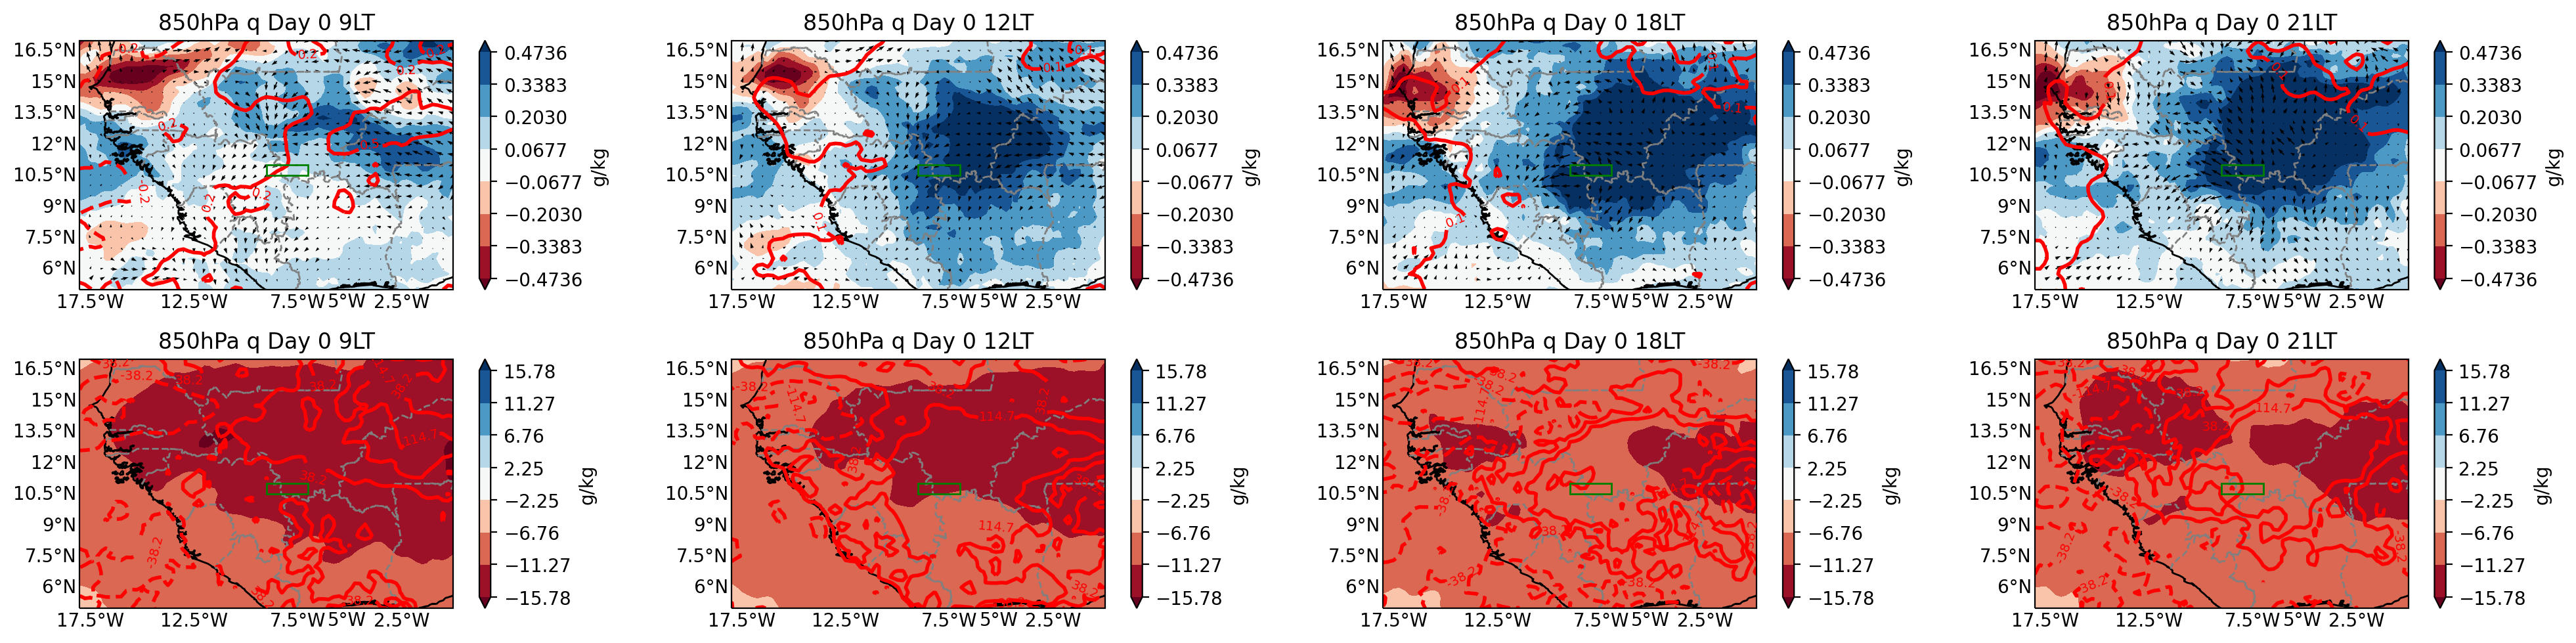

In [71]:
st=2
sarrow = 2
scale = 25
utag = 'u100'
vtag = 'v100'

f = plt.figure(figsize=(20,5), dpi=200)

hours_pick = [9, 12,18,21]
day_number = [0,0,0,0]
for ids, num in enumerate(day_number):

    ax = f.add_subplot(2,4,ids+1, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num, hours_pick[ids])
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u100_orig'], dic['v_orig']-dic['v100_orig'])
    vart = 'q'
    var = dic[vart]*1000
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,8) # edge*-1
    levs = [-1,0.1]
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
     
#     if vart == 'q':
#         vtags = '850hPa q'
#     if vart == 'qup':
#         vtags = '500hPa q'

    vart = 'q'     
    if vart == 'q':
        vtags = '850hPa q'
    if vart == 'qup':
        vtags = '500hPa q'
    
    cvar = 'qup'
    invar = dic[cvar]*1000
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,4) # edge*-1
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    draw_map(ax, var, lat, lon, title=vtags+' Day '+str(num)+' '+str(hours_pick[ids])+'LT',  quiver=qin, levels=lev, contour=contour)  #levels=lev,
    
    
for ids, num in enumerate(day_number):
    

    ax = f.add_subplot(2,4,ids+1+4, projection=ccrs.PlateCarree())
    print(num)
    dic, lat, lon = run(num, hours_pick[ids])
    dic = calc(dic)
    
    if ids == 0:
        lon2d, lat2d = np.meshgrid(lon,lat)
        xquiv = lon2d[sarrow::st, sarrow::st]
        yquiv = lat2d[sarrow::st, sarrow::st]
    #ipdb.set_trace()
    
    ws, wd = u_met.u_v_to_ws_wd(dic['u_orig']-dic['u100_orig'], dic['v_orig']-dic['v100_orig'])
    vart = 'shear'
    var = dic[vart]#*1000
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,1)),np.abs(np.percentile(var,99))])
        lev = np.linspace(edge*-1,edge,8) # edge*-1
    #ipdb.set_trace()
    u = dic[utag]
    v = dic[vtag]

    uu = u[sarrow::st, sarrow::st]
    vv = v[sarrow::st, sarrow::st]
    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : scale}
    
    
    cvar = 'cape'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,5)),np.abs(np.percentile(invar,95))])
        levs = np.linspace(edge*-1,edge,4) # edge*-1
    
    contour = {'data' : invar, 'x' : lon, 'y' : lat, 'levels' : levs}
    
    vart = 'shear'
    if vart == 'q':
        vtags = '850hPa q'
    if vart == 'qup':
        vtags = '500hPa q'
    
    draw_map(ax, var, lat, lon, title=vtags+' Day '+str(num)+' '+str(hours_pick[ids])+'LT', levels=lev, contour=contour)  #levels=lev,

f.canvas.draw()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/NFLICS/plots/cb_same/NFLICS_ERA5anomaly_dakarstorms_anom_sheartest_'+str(hours_pick[0])+'LT.jpg')